Data cleaning and preparation

In [1]:
import pandas as pd
from tabulate import tabulate
import pandasql as psql

In [3]:
patients_p_df = pd.read_parquet('../mimic-iii-clinical-database-1.4/parquet/patients_p.parquet') 

In [2]:
noteevents_df = pd.read_parquet('../mimic-iii-clinical-database-1.4/parquet/noteevents_p.parquet')

In [3]:
diagnoses_icd = pd.read_parquet('../../mimic_visualization/mimic-iii-clinical-database-1.4/parquet/diagnoses_icd_p.parquet') 

In [4]:
d_icd_diagnoses = pd.read_parquet('../../mimic_visualization/mimic-iii-clinical-database-1.4/parquet/d_icd_diagnoses_p.parquet') 

In [5]:
discharge_summary = noteevents_df.loc[noteevents_df['CATEGORY'] == 'Discharge summary', ['SUBJECT_ID', 'HADM_ID', 'TEXT']]
print(tabulate(discharge_summary.head(1), headers='keys', tablefmt='psql'))

+----+--------------+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |   SUBJECT_ID |   HADM_ID | TEXT                                                                                                                                                               |
|----+--------------+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 |        22532 |    167853 | Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]                                                                                             |
|    |              |           |                                                                                                                                                                    |
|    

In [6]:
''' Get ICD9 codes for tumor diagnoses from assignment#3 (sql)'''
tumor_icd9 = ['7310', '27788', '20020', 'v1091']

tumor_diagnoses = diagnoses_icd[diagnoses_icd['ICD9_CODE'].isin(tumor_icd9)]
print(tabulate(tumor_diagnoses.head(1), headers='keys', tablefmt='psql'))

+------+----------+--------------+-----------+-----------+-------------+
|      |   ROW_ID |   SUBJECT_ID |   HADM_ID |   SEQ_NUM |   ICD9_CODE |
|------+----------+--------------+-----------+-----------+-------------|
| 2314 |     1981 |          157 |    107880 |        19 |        7310 |
+------+----------+--------------+-----------+-----------+-------------+


In [7]:
tumor_diagnoses.count()

ROW_ID        104
SUBJECT_ID    104
HADM_ID       104
SEQ_NUM       104
ICD9_CODE     104
dtype: int64

In [8]:
tumor_discharge_summ_q = """SELECT ds.subject_id, 
                 ds.hadm_id, 
                 td.icd9_code, 
                case when '7310' then "Osteitis deformans without mention of bone tumor"
                     when '27788' then "Tumor lysis syndrome"
                     when '20020' then "Burkitt's tumor or lymphoma, unspecified site, extranodal and solid organ sites"
                     when 'v1091' then "Personal history of malignant neuroendocrine tumor"
                     else 'Other' 
                end as long_title,
                text as notes
            FROM tumor_diagnoses td
            INNER JOIN discharge_summary ds
            ON ds.subject_id = td.subject_id
            and ds.hadm_id = td.hadm_id"""

# Execute the query
tumor_discharge_summ = psql.sqldf(tumor_discharge_summ_q, locals())


In [ ]:
#print(tabulate(tumor_discharge_summ.head(1), headers='keys', tablefmt='psql'))

SpaCy Extraction and Tokenization

In [10]:
!pip uninstall spacy -y


In [11]:
!pip install spacy==3.8

  Using cached spacy-3.8.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (27 kB)
Reason for being yanked: model compatibility problem
Using cached spacy-3.8.0-cp312-cp312-macosx_11_0_arm64.whl (5.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-ner-jnlpba-md 0.5.4 requires spacy<3.8.0,>=3.7.4, but you have spacy 3.8.0 which is incompatible.
en-ner-bc5cdr-md 0.5.4 requires spacy<3.8.0,>=3.7.4, but you have spacy 3.8.0 which is incompatible.
en-ner-bionlp13cg-md 0.5.4 requires spacy<3.8.0,>=3.7.4, but you have spacy 3.8.0 which is incompatible.
en-core-sci-sm 0.5.4 requires spacy<3.8.0,>=3.7.4, but you have spacy 3.8.0 which is incompatible.
en-core-sci-md 0.5.4 requires spacy<3.8.0,>=3.7.4, but you have spacy 3.8.0 which is incompatible.
scispacy 0.5.5 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.8.0 which is incompatible.
en-core-sci-lg 0.5.4 require

In [103]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [104]:
''' function to extract tokens from text by removing stop words and punctuation using spacy'''
'''modifying function to remove number too'''
def tokenize_text_spacy(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not (token.is_punct | token.is_digit | token.is_stop)]
    tokens = [token for token in tokens if token not in STOP_WORDS]
    all_tokens = ' '.join(tokens)
    return all_tokens


In [105]:
tumor_discharge_summ['spacy_token_notes'] = tumor_discharge_summ['notes'].apply(lambda x: tokenize_text_spacy(x))

In [107]:
#print(tabulate(tumor_discharge_summ.head(1), headers='keys', tablefmt='psql'))

In [14]:
''' Extract entities from the text using spacy'''
def extract_entities_spacy(text):
    doc = nlp(text)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print("*********************************************************")
    return doc

In [15]:
extract_entities_spacy(tumor_discharge_summ.iloc[0]['notes'])

Admission Date:   0 17 ORG
2106-6-17 20 29 DATE
2106-6-24 67 76 DATE
2025-12-3 100 109 DATE
Succinylcholine / Aspirin 165 190 ORG
Name3 (LF 211 220 ORG
465 222 225 CARDINAL
NH 402 404 ORG
USOH 469 473 ORG
3.30am 480 486 CARDINAL
NH 503 505 ORG
7.48/25/66/18.7 586 601 ORG
SBP 607 610 GPE
70s 618 621 DATE
Vanc 705 709 ORG
WBC 759 762 ORG
25.7 763 767 CARDINAL
133 775 778 CARDINAL
18 820 822 CARDINAL
PE 844 846 ORG
ED 854 856 ORG
this morning 864 876 TIME
103 1024 1027 CARDINAL
5 1037 1038 CARDINAL
IVF w/ inc 1073 1083 ORG
BP 1087 1089 GPE
111/49 1093 1099 CARDINAL
1 1101 1102 CARDINAL
Vanc/levo/flagyl 1108 1124 ORG
1 1161 1162 CARDINAL
UTI 1236 1239 ORG
7d 1280 1282 CARDINAL
PO Cipro 1290 1298 FAC
153 1342 1345 CARDINAL
5-18 1617 1621 CARDINAL
5-21 1632 1636 CARDINAL
UTI 1733 1736 ORG
5-15 1776 1780 CARDINAL
392 1909 1912 CARDINAL
MA 1917 1919 ORG
Family History 2023 2037 PERSON
98.4 2079 2083 CARDINAL
115 2089 2092 CARDINAL
109/82 2098 2104 CARDINAL
O2 2113 2115 PERSON
88% 2122 2125 PER

Admission Date:  [**2106-6-17**]              Discharge Date:   [**2106-6-24**]

Date of Birth:  [**2025-12-3**]             Sex:   M

Service: MEDICINE

Allergies:
Succinylcholine / Aspirin

Attending:[**First Name3 (LF) 465**]
Chief Complaint:
Sepsis, respiratory failure

Major Surgical or Invasive Procedure:
Intubation, extubation, central line/PICC placement


History of Present Illness:
80y M, NH resident s/p recent subdural hematoma evacuation who
was in his USOH until 3.30am today when (per NH records) he
suddenly became hypotensive and hypoxic. A STAT ABG at the time
was 7.48/25/66/18.7, his SBP was in 70s and was treated with IV
NS, x2 bld cx were drawn and the pt was started on empiric Vanc
for presumed UTI. His labs were significant for: WBC 25.7 and Na
133.  The pt was transferred to [**Hospital1 18**] to r/o sepsis and PE.
.
Per ED notes, this morning pt was also noted to have increasing
confusion, decreased urine output, fever and elevated white cell
count. He was tachyca

In [109]:
#displacy.render(nlp(tumor_discharge_summ.iloc[0]['notes']), style='ent', jupyter=True)

SciSpacy tokenization and entity recognition

In [17]:
!pip uninstall spacy -y
!pip install spacy==3.7.5
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_craft_md-0.5.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_jnlpba_md-0.5.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bionlp13cg_md-0.5.4.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz
!pip install gensim
!pip install transformers

Found existing installation: spacy 3.8.0
Uninstalling spacy-3.8.0:
  Successfully uninstalled spacy-3.8.0
  Using cached spacy-3.7.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (27 kB)
Using cached spacy-3.7.5-cp312-cp312-macosx_11_0_arm64.whl (6.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
medspacy 1.3.1 requires spacy<4.0,>=3.8; python_version >= "3.12", but you have spacy 3.7.5 which is incompatible.
pyrush 1.0.9 requires spacy>=3.8; python_version >= "3.12", but you have spacy 3.7.5 which is incompatible.
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz (119.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_craft_md-0.5.4.tar.gz (119.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached https://s3

In [87]:
!pip uninstall en_core_sci_sm -y
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

Found existing installation: en_core_sci_sm 0.2.4
Uninstalling en_core_sci_sm-0.2.4:
  Successfully uninstalled en_core_sci_sm-0.2.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 9.0 MB/s eta 0:00:00a 0:00:01m
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_sci_sm: filename=en_core_sci_sm-0.5.4-py3-none-any.whl size=14778488 sha256=87574e5f69bf8f40c7d89ae99021dfa495291f3a7a0b8e8b53948e0af2f32cd2
  Stored in directory: /Users/sowmyasrinath/Library/Caches/pip/wheels/49/7f/0f/ec0fc3a935bfe55e6ef2ca04b7a31e33cbd533a6d7cbd9e11e
Successfully built en_core_sci_sm


In [24]:
from spacy.lang.en import English

ModuleNotFoundError: No module named 'spacy.lang.en'

In [18]:
import en_core_sci_lg
nlp_scispacy = en_core_sci_lg.load()

/opt/anaconda3/envs/AIHC/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_lg' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [19]:
''' function to extract tokens from text by removing stop words and punctuation using scispacy en_core_sci_lg model'''

def tokenize_text_scispacy(text):
    doc = nlp_scispacy(text)
    tokens = [token.text for token in doc if not (token.is_punct | token.is_digit | token.is_stop)]
    tokens = [token for token in tokens if token not in STOP_WORDS]
    all_tokens = ' '.join(tokens)
    return all_tokens

In [24]:
''' Apply scispacy en_core_sci_lg model to same tumor dataset and observe the difference '''
tumor_discharge_summ['scispacy_token_notes'] = tumor_discharge_summ['notes'].apply(lambda x: tokenize_text_scispacy(x))

In [111]:
#print(tabulate(tumor_discharge_summ.head(1), headers='keys', tablefmt='psql'))

In [20]:
def extract_entities_scispacy(text, display):
    doc = nlp_scispacy(text)
    if display:
        for ent in doc.ents:
            print(ent.text, ent.start_char, ent.end_char, ent.label_)
        print("*********************************************************")
    return doc

In [96]:
extract_entities_scispacy(tumor_discharge_summ.iloc[0]['notes'], True)

Admission 0 9 ENTITY
Date 10 14 ENTITY
Birth 89 94 ENTITY
Sex 125 128 ENTITY
Succinylcholine 165 180 ENTITY
Aspirin 183 190 ENTITY
Name3 211 216 ENTITY
LF 218 220 ENTITY
Sepsis 246 252 ENTITY
respiratory failure 254 273 ENTITY
Surgical 281 289 ENTITY
Invasive Procedure 293 311 ENTITY
Intubation 313 323 ENTITY
extubation 325 335 ENTITY
central line/PICC placement 337 364 ENTITY
NH 402 404 ENTITY
evacuation 443 453 ENTITY
USOH 469 473 ENTITY
NH records 503 513 ENTITY
hypotensive 534 545 ENTITY
hypoxic 550 557 ENTITY
STAT 561 565 ENTITY
ABG 566 569 ENTITY
SBP 607 610 ENTITY
treated with 630 642 ENTITY
IV 643 645 ENTITY
NS 646 648 ENTITY
x2 bld cx 650 659 ENTITY
empiric 697 704 ENTITY
Vanc 705 709 ENTITY
UTI 723 726 ENTITY
labs 732 736 ENTITY
WBC 759 762 ENTITY
Na 772 774 ENTITY
transferred 792 803 ENTITY
r/o sepsis 829 839 ENTITY
PE 844 846 ENTITY
ED 854 856 ENTITY
notes 857 862 ENTITY
morning 869 876 ENTITY
increasing 903 913 ENTITY
confusion 914 923 ENTITY
decreased 925 934 ENTITY
urine

Admission Date:  [**2106-6-17**]              Discharge Date:   [**2106-6-24**]

Date of Birth:  [**2025-12-3**]             Sex:   M

Service: MEDICINE

Allergies:
Succinylcholine / Aspirin

Attending:[**First Name3 (LF) 465**]
Chief Complaint:
Sepsis, respiratory failure

Major Surgical or Invasive Procedure:
Intubation, extubation, central line/PICC placement


History of Present Illness:
80y M, NH resident s/p recent subdural hematoma evacuation who
was in his USOH until 3.30am today when (per NH records) he
suddenly became hypotensive and hypoxic. A STAT ABG at the time
was 7.48/25/66/18.7, his SBP was in 70s and was treated with IV
NS, x2 bld cx were drawn and the pt was started on empiric Vanc
for presumed UTI. His labs were significant for: WBC 25.7 and Na
133.  The pt was transferred to [**Hospital1 18**] to r/o sepsis and PE.
.
Per ED notes, this morning pt was also noted to have increasing
confusion, decreased urine output, fever and elevated white cell
count. He was tachyca

In [114]:
#displacy.render(nlp_scispacy(tumor_discharge_summ.iloc[0]['scispacy_token_notes']), style='ent', jupyter=True)

In [100]:
#sentence identifier
sentences = extract_entities_scispacy(tumor_discharge_summ.iloc[0]['notes'], False)
for i in range(len(sentences)):
  for ix, sent in enumerate(sentences[i].sents, 1):
    print("Sentence number {}:{}".format(ix, sent))
  print('*******************************************************************************************')

AttributeError: 'spacy.tokens.token.Token' object has no attribute 'sents'

In [21]:
pd.options.mode.chained_assignment = None
import numpy as np

In [22]:
nlp_web_sm = spacy.load('en_core_web_sm')

Word2Vec model for Tumor dataset

In [26]:
tumor_corpus = []
for row in range(0, len(tumor_discharge_summ)):
  str_tokens=[]
  tokens= nlp_web_sm(tumor_discharge_summ.iloc[row]['scispacy_token_notes']).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  tumor_corpus.append(list(str_tokens))

In [27]:
print(len(tumor_corpus))
print(tumor_corpus[:10])

112
[['Admission Date                 Discharge Date', 'Complaint \n Sepsis', 'Major Surgical Invasive Procedure \n Intubation', '80y', 'USOH', '3.30am', 'today', 'NH', '70s', 'IV \n NS', 'Vanc \n ', 'UTI', 'WBC', '25.7', 'ED', '80s', 'IVF w/ inc BP', '111/49', 'Vanc/levo/flagyl \n \n Recent admission Date', 'ED', 'UTI', '7d', 'PO Cipro', 'Hospital Unit', 'diet', 'UTI \n h/o MSSA \n ', 'Social History \n Lives', 'MA Divorced', '98.4', '15L \n ', 'LAD', 'DOB', 'Tone LUE > RUE Downgoing', '9.0', 'CBC', '31.7->29.8', 'RLL', 'ETT', 'cm carina', '5:30 pm', '100,000', '10,000 100,000', 'MIC', 'MCG', 'ML \n\n \n                              ', '11:05 pm', 'SPECIMEN', '1000X', 'FIELD    GRAM', '10,000 100,000', '100,000', 'Microbiology Laboratory 7-/2406 \n ', 'MIC', 'MCG', 'ML \n\n \n                              STAPH AUREUS COAG +', '0.5', '0.5', '0.5', '12:00 pm', '1000X', 'FIELD    POLYMORPHONUCLEAR \n ', 'LEGIONELLA CULTURE Preliminary     LEGIONELLA', 'DM', 'Hospital Unit w/', 'Hospital

In [33]:
from gensim.models import Word2Vec
tumor_model = Word2Vec(tumor_corpus, min_count=1)

In [34]:
tumor_model.wv.key_to_index.keys()

dict_keys(['Tablet', 'daily', 'CT', 'PO', 'Tablet PO', 'Tablet(s', 'CXR', 'ICU', '0.5', 'WBC', 'Known', 'Admission Date                 Discharge Date', 'weeks', 'days', 'STitle', 'Tablet Sig', 'GI', 'ED', 'Name11', 'day', 'NI', 'Tablet PO BID', 'today', 'MD', 'INR', '2.5', 'CT \n ', '8.6', 'PCP', 'Patient \n ', 'SOB', 'Followup Instructions \n ', 'Tablet PO DAILY \n Daily', 'CSF', 'second', 'Left', 'EGD', 'CHF', 'Hospital Unit', 'Burkitt', 'AML', '12:00AM', '0.25', 'Denies', 'un', 'Tablet PO DAILY Daily', 'EKG', 'Tablet PO DAILY Daily \n ', 'DNR', 'hours', 'UREA', 'CAD', 'CVA', 'years', 'IV', 'Hospital', 'years ago', 'LAD', 'evening', '2L', 'ST', 'NAD', 'mm', 'S1 S2', 'MD MD', 'morning', 'ICU \n ', 'Patient', 'Known Allergies Drugs', 'Tablet Tablet(s', 'Cardiac', 'Tablet PO BID \n ', 'VS', 'UTI', '100,000', '06:30AM', 'EtOH', 'TOT', '5/5', 'Tablet Sig Tablets PO', 'II-XII', 'MCG', 'MIC', 'UA', 'CBC', '1.5', '12.5', 'Discharge Instructions \n ', 'Monday', 'Overall', 'Tablet PO \n ', 'I

In [49]:
tumor_model.wv['Burkitt']

array([-0.00213416,  0.00893602, -0.00724719, -0.00925983, -0.00510542,
       -0.0046803 , -0.00604421, -0.00439344, -0.01149017, -0.00344985,
        0.0058258 , -0.01275629, -0.00476645,  0.00240623,  0.00568787,
       -0.01045965,  0.00851136, -0.01094626,  0.0054021 ,  0.00321868,
        0.00801455,  0.0075452 ,  0.00948493,  0.00222347, -0.00676727,
        0.00672029, -0.0096462 , -0.00790882,  0.00329125, -0.00897287,
       -0.00417233, -0.00267517,  0.00363352,  0.0029232 ,  0.00197422,
        0.00592599, -0.00155373,  0.00373108, -0.00855813, -0.00568039,
       -0.0078314 , -0.00164541,  0.00374593,  0.005485  , -0.00268846,
       -0.0001742 ,  0.00518092, -0.00608275, -0.00176304,  0.00220374,
       -0.00436004,  0.00710749,  0.00607253,  0.00812495,  0.00867073,
       -0.0072971 ,  0.00090823, -0.00770434, -0.0066154 , -0.00739299,
        0.00437841,  0.00099155, -0.0075447 ,  0.0092753 , -0.00227295,
        0.00267799, -0.00423107, -0.00347971, -0.00442726,  0.01

In [54]:
tumor_model.wv.most_similar('Burkitt')

[('mcg daily', 0.3580041825771332),
 ('Hgb-9.5', 0.32999375462532043),
 ('afib coumadin MVR COPD HTN \n ', 0.32918331027030945),
 ('Fluid overload- Patient', 0.3261355459690094),
 ('Trivora', 0.31687667965888977),
 ('Metastatic', 0.3121810555458069),
 ('Atyps-0 Metas-0 Myelos-0 Other-82', 0.30772504210472107),
 ('mCi', 0.3040127754211426),
 ('0.083 0.83 mg/mL Solution Sig \n Inhalation Q6H hours', 0.3019416630268097),
 ('91.4KG', 0.29983291029930115)]

In [68]:
tumor_model.wv.most_similar('Tumor')

[('Ritalin', 0.35911521315574646),
 ('Neuts-58 Bands-0 Lymphs-41 Monos-0 Eos-1 \n Baso-0', 0.34518957138061523),
 ('PO DAILY', 0.32983237504959106),
 ('ERCP', 0.3280452489852905),
 ('EUCERIN    Cream', 0.3201485872268677),
 ('Location un \n Campus', 0.31308069825172424),
 ('CNS/Leptomeningeal Involvement CML', 0.31194421648979187),
 ('LF NI NI', 0.3019699454307556),
 ('Antibiotics', 0.2963160276412964),
 ('Followup Instructions \n Oncology', 0.28788092732429504)]

In [56]:
tumor_model.wv.similarity('Burkitt', 'Lymphoma')

-0.095041424

In [57]:
tumor_model.wv.similarity('Burkitt', 'Tumor')

0.017246637

In [66]:
tumor_model.wv.similarity('CT Chest', 'Cardiac')

0.044971853

In [146]:
import en_ner_bc5cdr_md
med_nlp = en_ner_bc5cdr_md.load()
doc = med_nlp(tumor_discharge_summ.iloc[0]['notes'])
displacy.render(doc, style="ent", jupyter=True)

/opt/anaconda3/envs/AIHC/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Plot Tumor entities

In [69]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [70]:
def tsne_plot(model,words, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
      if preTrained:
          tokens.append(model[word])
      else:
          tokens.append(model.wv[word])
      labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [76]:
vocabs = tumor_model.wv.key_to_index.keys()
len(vocabs)

6381

In [118]:
new_vocabs = list(vocabs)[:100]
len(new_vocabs)
#

100

/opt/anaconda3/envs/AIHC/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


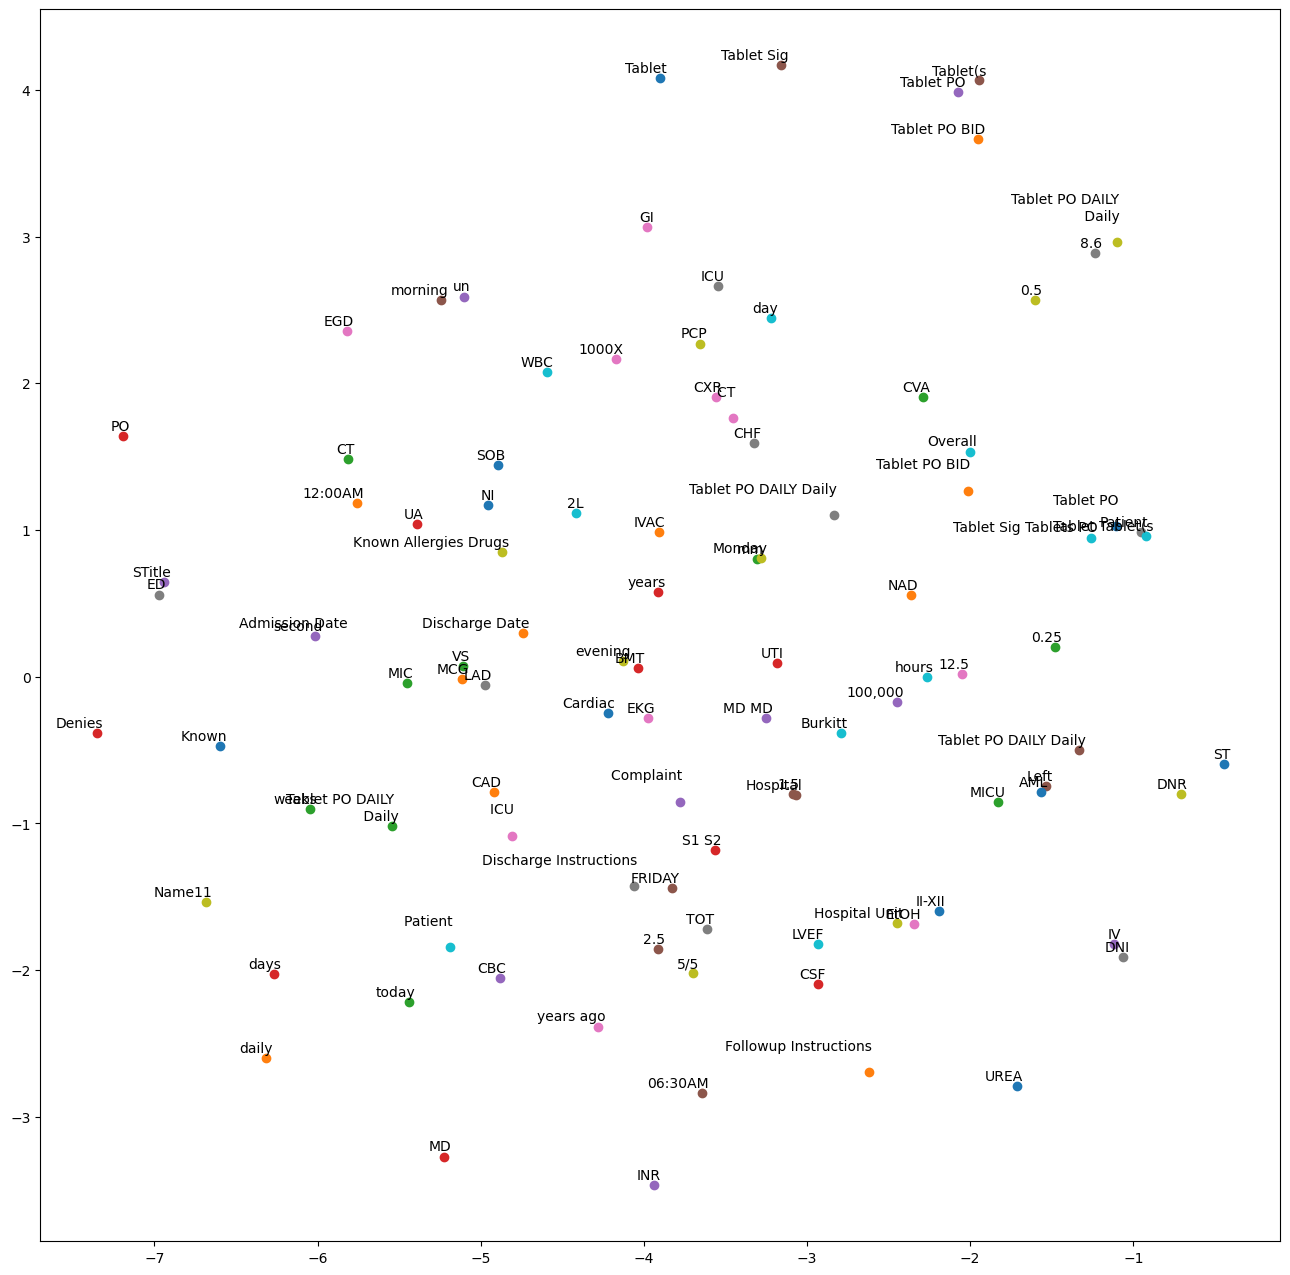

In [119]:
tsne_plot(tumor_model,new_vocabs)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("mps") if torch.has_mps else torch.device("cpu")

# Load the BlueBERT model and tokenizer
model_name = "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12"
tokenizer = AutoTokenizer.from_pretrained(model_name).to(device)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [128]:

bluebert_tokens = tokenizer.tokenize(tumor_discharge_summ.iloc[0]['notes'])
#print(tokens)

In [129]:
print(bluebert_tokens)

['admission', 'date', ':', '[', '*', '*', '210', '##6', '-', '6', '-', '17', '*', '*', ']', 'discharge', 'date', ':', '[', '*', '*', '210', '##6', '-', '6', '-', '24', '*', '*', ']', 'date', 'of', 'birth', ':', '[', '*', '*', '202', '##5', '-', '12', '-', '3', '*', '*', ']', 'sex', ':', 'm', 'service', ':', 'medicine', 'all', '##er', '##gies', ':', 'su', '##cci', '##ny', '##lch', '##olin', '##e', '/', 'as', '##pi', '##rin', 'attending', ':', '[', '*', '*', 'first', 'name', '##3', '(', 'l', '##f', ')', '46', '##5', '*', '*', ']', 'chief', 'complaint', ':', 'sep', '##sis', ',', 'respiratory', 'failure', 'major', 'surgical', 'or', 'invasive', 'procedure', ':', 'int', '##uba', '##tion', ',', 'ex', '##tub', '##ation', ',', 'central', 'line', '/', 'pic', '##c', 'placement', 'history', 'of', 'present', 'illness', ':', '80', '##y', 'm', ',', 'nh', 'resident', 's', '/', 'p', 'recent', 'sub', '##dur', '##al', 'hem', '##ato', '##ma', 'evacuation', 'who', 'was', 'in', 'his', 'us', '##oh', 'until',